# BBC News Classification

The goal of this project is to build a model for news articles classification.

I decided not use word embedding in this project, like Word2Vec or GloVe. That's because those techniques represent each word with a vector and identify semantic relationships between words. This would not be useful in my case, and I also don't have a large dataset to train such models. Instead, I will use TF-IDF measure to evaluate the frequency and importance of words and this will help classifying the articles to the correct category.

After having the words represented with TF-IDF, I will use matrix factorization to predict the category, and then compare it to logistic regression model.

### Exploratory data analysis

I will load the data and display a few rows

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

train_data = pd.read_csv('learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('learn-ai-bbc/BBC News Test.csv')

train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


Number of articles per category

<Axes: xlabel='Category'>

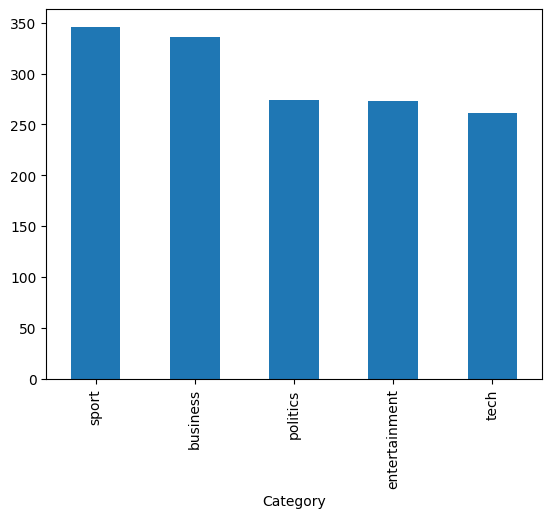

In [5]:
train_data['Category'].value_counts().plot(kind='bar')

Ok, so I have a train set of 1490 articles, divided into 5 categories, more or less evenly distributed.

Now, I'll check an example of a text:

In [6]:
train_data['Text'][409]

'actor scott is new bond favourite bookmaker william hill has stopped taking bets on who will be the next james bond  following a succession of large wagers on actor dougray scott.  the firm closed the book on friday  saying  insider information  could have contributed to the number of bets.  in the past gambles like this have often been right   william hill spokesman rupert adams said. the closing list gave scott odds of 6-9  followed by oscar nominee clive owen at 5-2. scott first found fame in the tv series soldier soldier and has since then starred in such films as mission impossible ii and the wartime drama enigma.  mr adams said one punter had placed a bet of £870 on the 39-year-old actor at odds of 8-1.  she told us she had some inside information  perhaps she knew he had been to a casting  but she wouldn t say   he said. others thought to be in the running include star wars actor ewan mcgregor and australian star hugh jackman  both of whom have odds of 4-1. colin farrell  jude 

I see that the text is lowercase and contains dots and other symbols. I'll check the number of words per article per category:

<Axes: xlabel='Category', ylabel='word_count'>

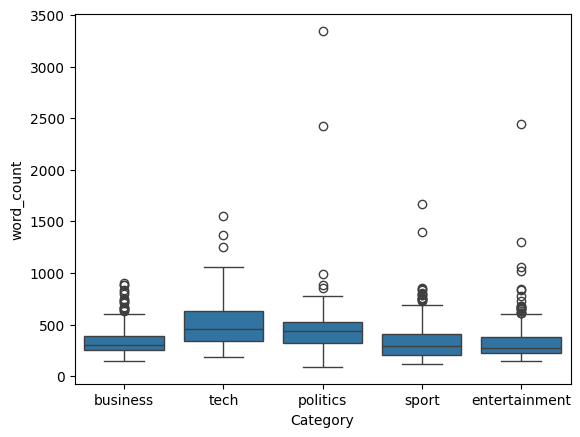

In [7]:
train_data['word_count'] = train_data['Text'].apply(lambda x: len(x.split()))
sns.boxplot(x='Category', y='word_count', data=train_data)

Number of words per article is more or less the same across all categories, with a few outliers in the politics and entertainment categories.

### Data Cleaning and Feature Extraction

I will combine data cleaning with feature extraction, because most of the cleaning will be done in the process of creating the word features.

First I will remove duplicates and outliers:

In [8]:
print('Number of duplicates before removing:', train_data.duplicated(subset=['Text']).sum())
train_data = train_data.drop_duplicates(subset='Text', keep='first')

train_data['word_count'] = train_data['Text'].apply(lambda x: len(x.split()))
print('Number of outliers before removing:', train_data[train_data['word_count'] >= 2000].shape[0])
train_data = train_data[train_data['word_count'] < 2000]

Number of duplicates before removing: 50
Number of outliers before removing: 3


Now I want to address the non-alphanumeric characters in the text. Let's see how many of them are there:

In [9]:
# find all unique non-alphanumeric characters in the text
non_alphanumeric = set()
for text in train_data['Text']:
    non_alphanumeric.update(re.findall(r'[^a-zA-Z0-9\s]', text))
print(non_alphanumeric)

{';', '(', '/', '#', '&', '.', '=', ':', '$', '!', '[', '+', ']', '£', '`', '%', ')', '*', '-'}


Instead of removing the non-alphanumeric characters, I will double-quote them and add spaces before and after. The reason is that I want all these charachters to be treated as separate words in the tokenization step. Symbols like $, £ or % can have a higher frequency in some categories and can be useful for the classification.

In [10]:
train_data['Text'] = train_data['Text'].apply(lambda x: re.sub(r'([^a-zA-Z0-9\s])', r' "\1" ', x))

Actually, I will not remove any words from the text, even stopwords like 'a', 'to', 'from', etc. I will explain why shortly, but before that I want to see how words distribute accross categories:

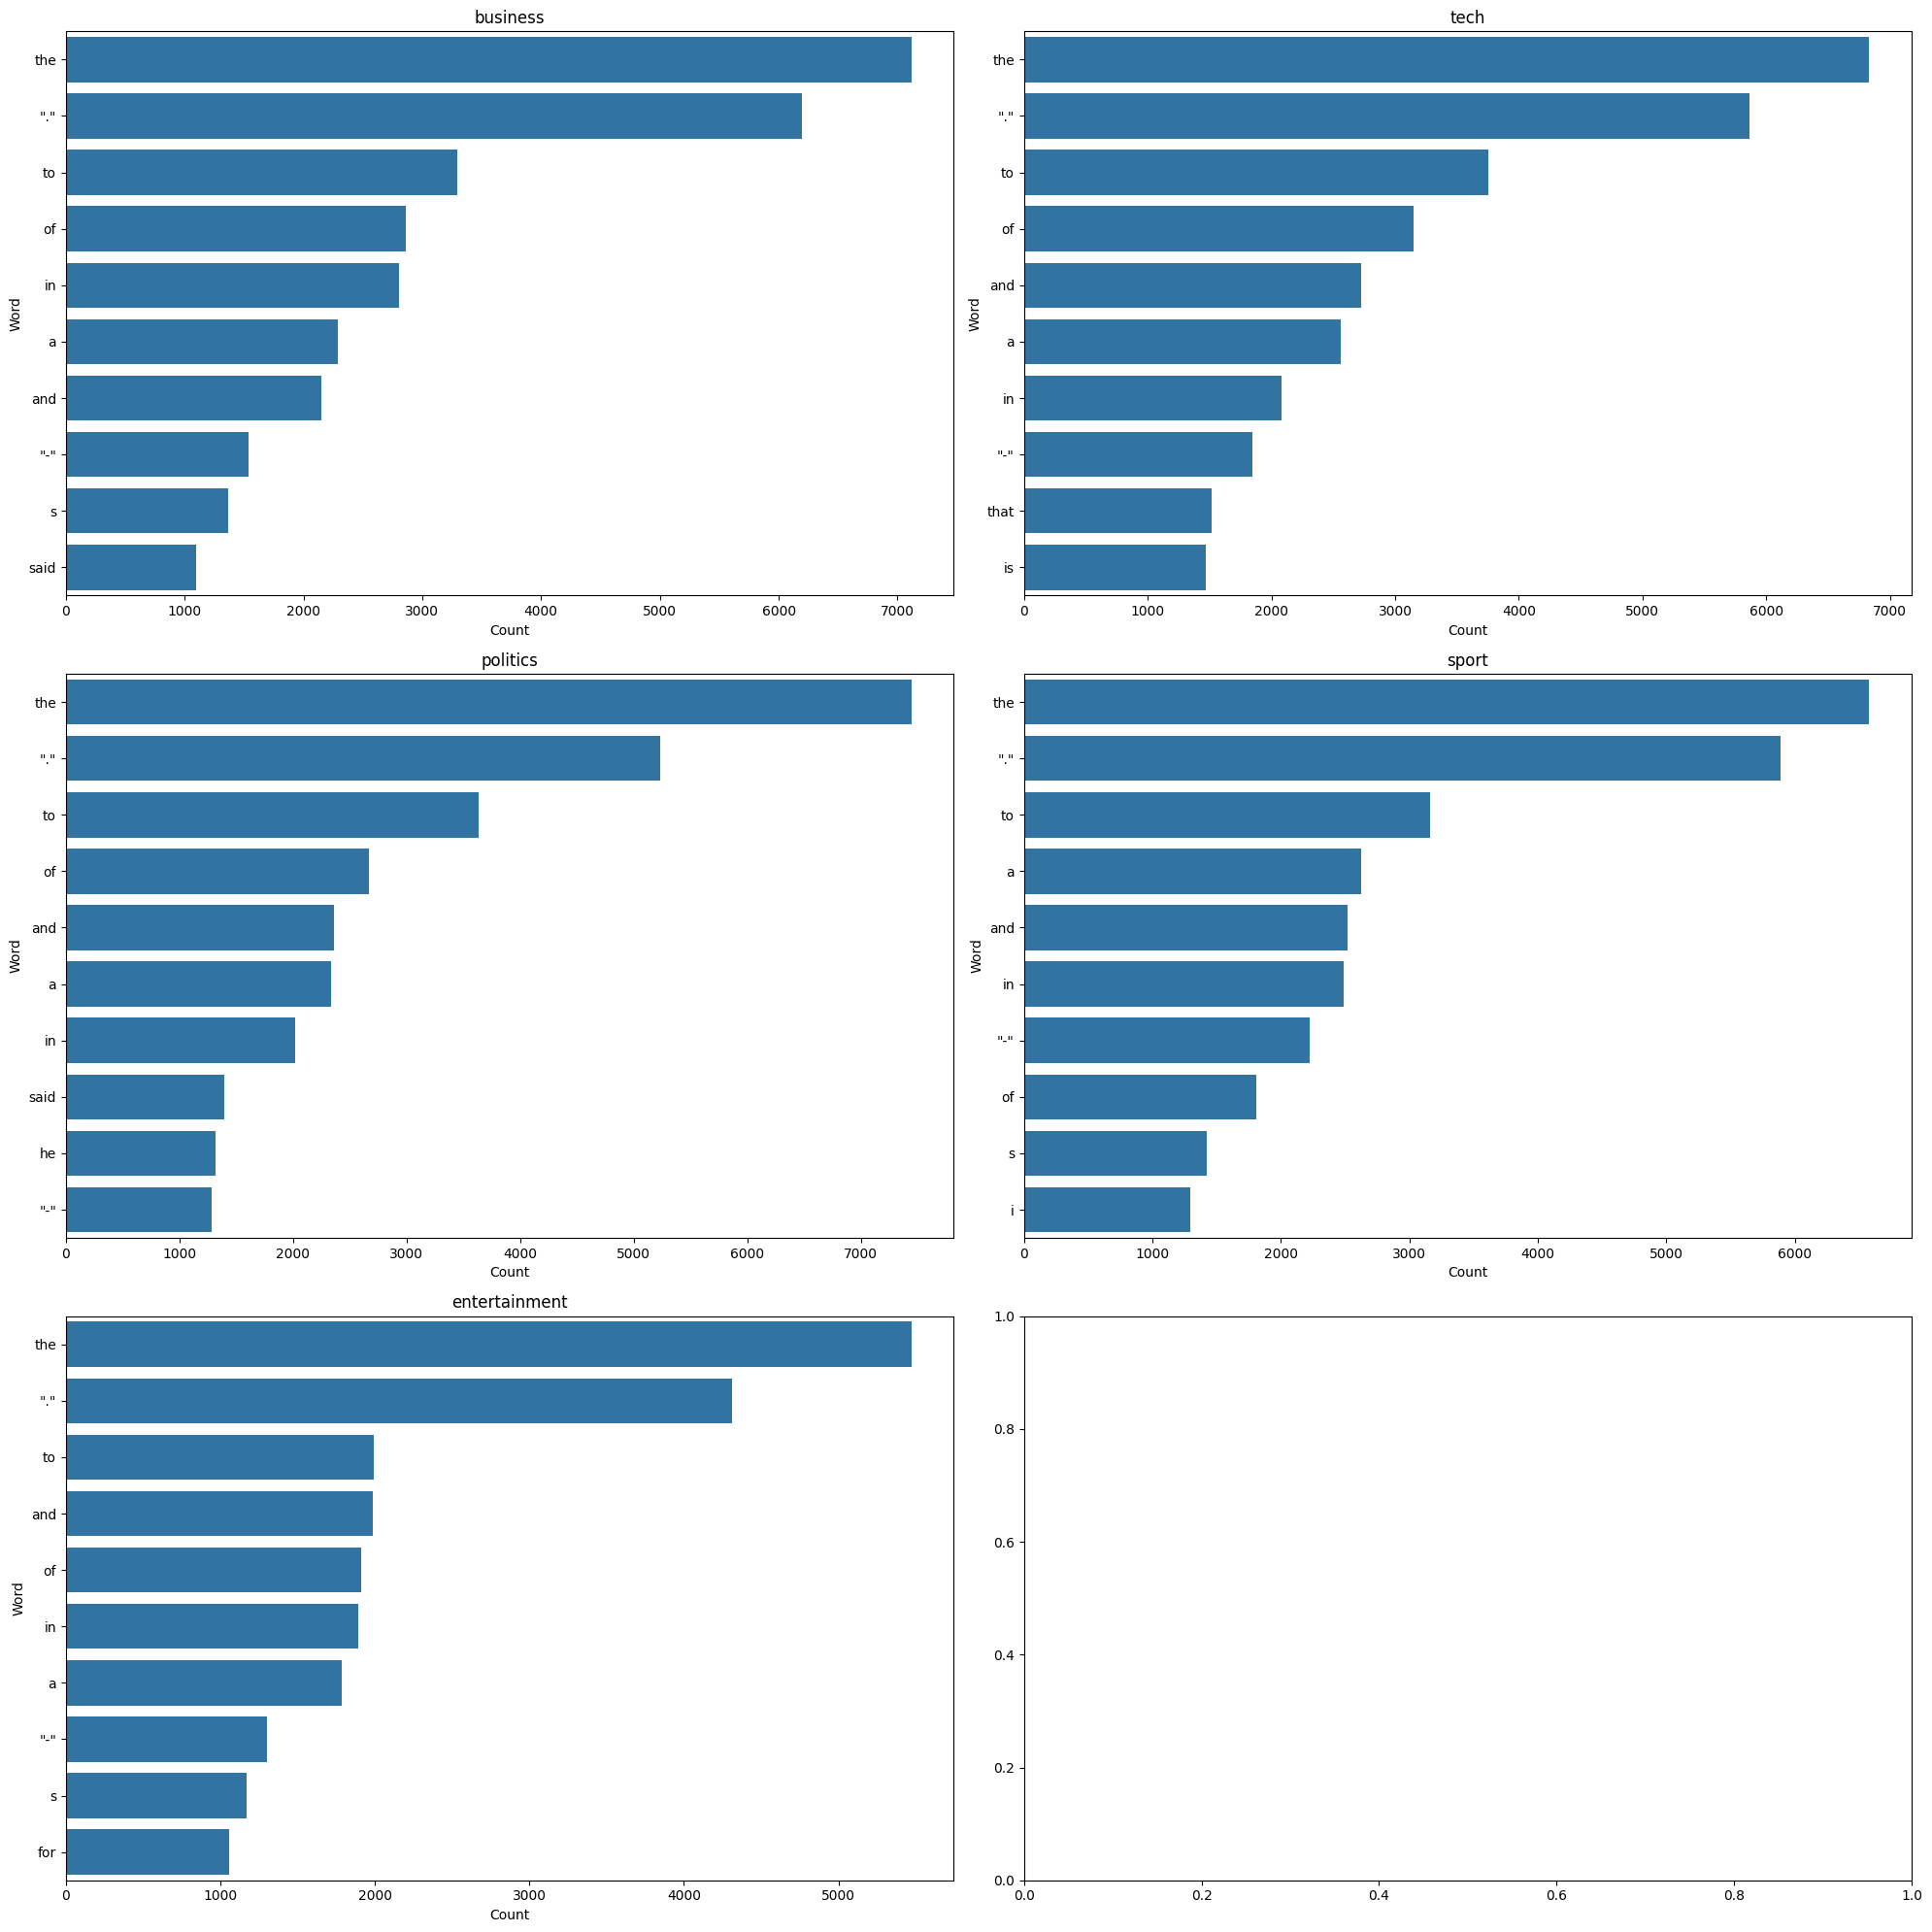

In [11]:
from collections import Counter

words_freq = {}
for category in train_data['Category'].unique():
    words_freq[category] = Counter()
    for text in train_data[train_data['Category'] == category]['Text']:
        words_freq[category].update(text.split())

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()
for i, (category, freq) in enumerate(words_freq.items()):
    words, counts = zip(*freq.most_common(10))
    sns.barplot(x=counts, y=words, ax=axes[i])
    axes[i].set_title(category)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Word')
plt.tight_layout()
plt.show()

Not surprizingly, the most common words are stop-words, which do not help in distinguishing between the categories. And now it's  time to apply the TF-IDF technique and see how it ranks the words according to their importance and frequency.

The TF-IDF (Term Frequency-Inverse Document Frequency) is a measure that shows how important a word is to a document in a collection of documents. The formula for calculating the TF-IDF is: TF-IDF = TF * IDF where TF is the term frequency in a document and IDF is the inverse document frequency. For example if a word appears many times in a document but not in other documents then the TF-IDF score will be high.

My assumption is that this measure will be similar for articles in the same category (between corresponding words), and this will help classifying the test set.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# The params I used:
# max_features: 2000, the maximum number of features (words)
# max_df: 0.3, the maximum document frequency of a word to be included
# token_pattern: r'\S{2,}', the regular expression pattern to extract words of length 2 or more
vectorizer = TfidfVectorizer(max_features=2000, max_df=0.3, token_pattern=r'\S{2,}').fit(train_data['Text'])

And now I want to check the most common words for each category again, sorted by the TF-IDF value:

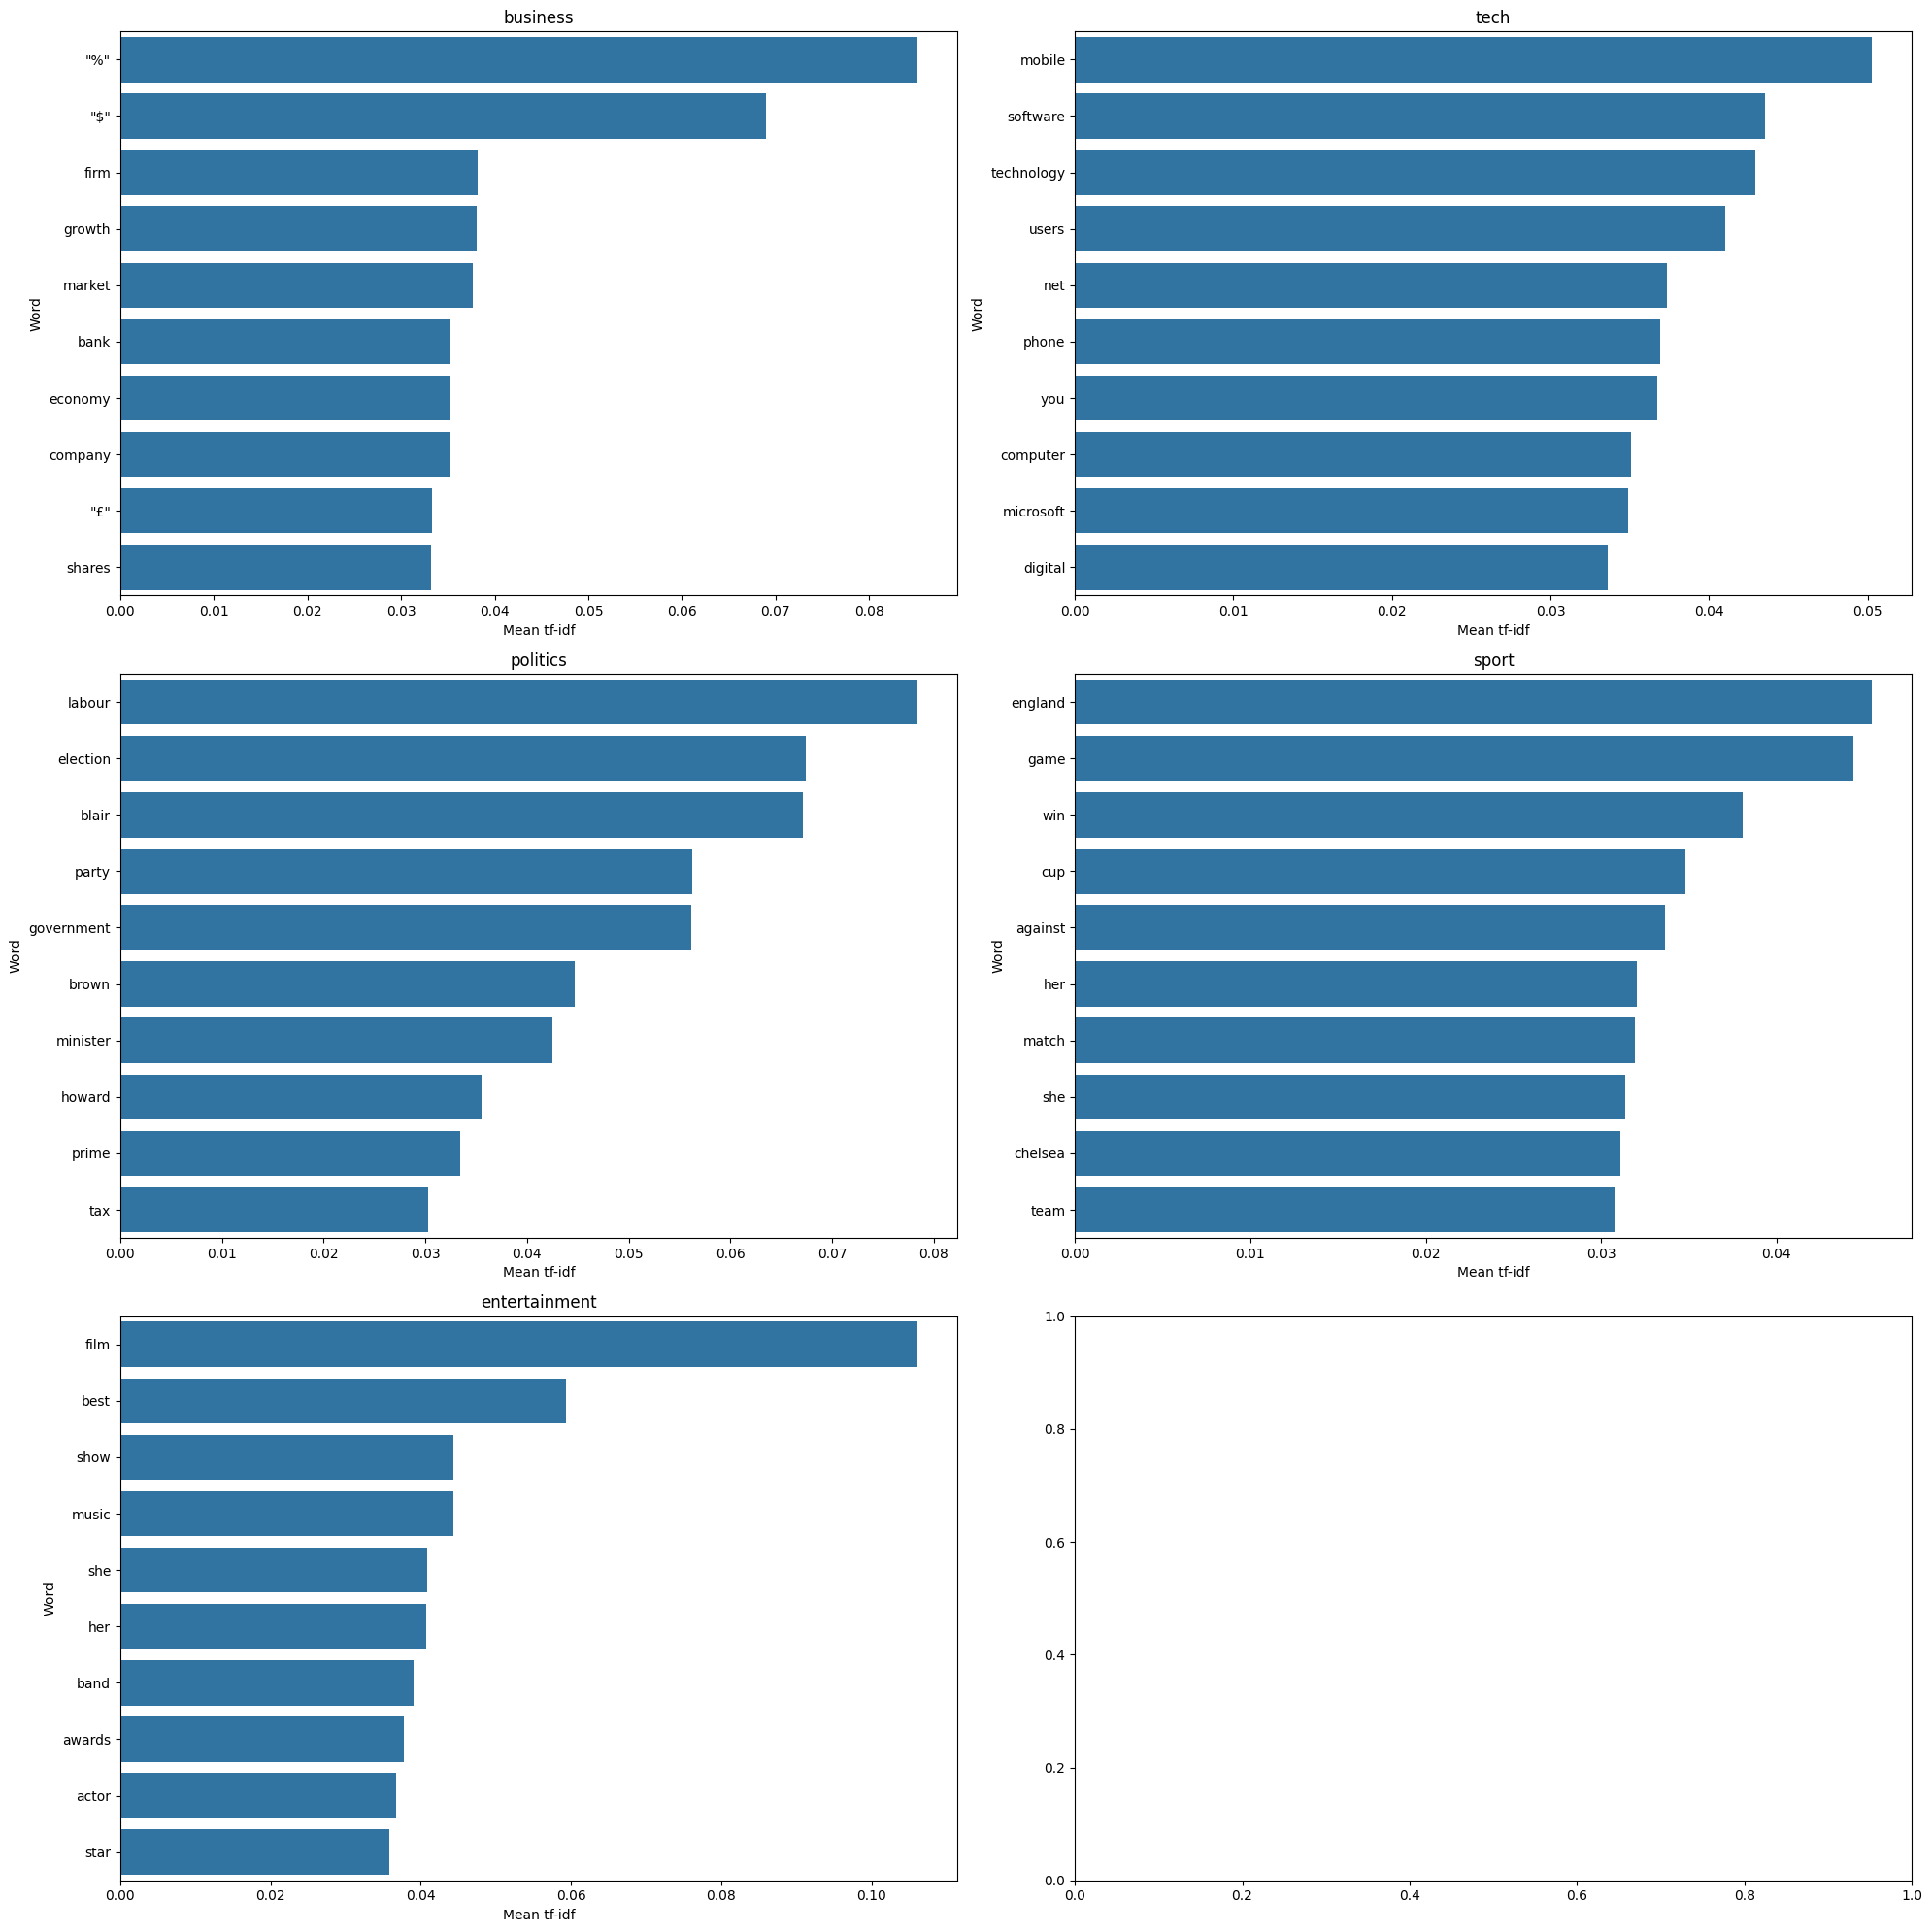

In [13]:
feature_names = np.array(vectorizer.get_feature_names_out())

category_words = {}

# For each category get the list of words and their mean tf-idf value across that category
for category in train_data['Category'].unique():
    category_text = train_data[train_data['Category'] == category]['Text']
    X_category = vectorizer.transform(category_text)
    category_words[category] = np.mean(X_category.toarray(), axis=0)

category_words_df = pd.DataFrame(category_words, index=feature_names)
category_words_df

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()
for i, category in enumerate(train_data['Category'].unique()):
    top_words = category_words_df[category].nlargest(10)
    sns.barplot(x=top_words.values, y=top_words.index, ax=axes[i])
    axes[i].set_title(category)
    axes[i].set_xlabel('Mean tf-idf')
    axes[i].set_ylabel('Word')
plt.tight_layout()
plt.show()


Those results make much more sense, as words looks very relevant to their category. There are almost no stop-words as those are filtered out by the max_df=0.3 argument, which makes sure the selected words appear in less then 30% of the articles.

### Matrix Factorization Model

I will use the combined data (train + test) for building the model, as it will give more accurate values for TF-IDF. Another reason to include both train and test set, it that I will need to find the mapping between the categories and the components of the W matrix, and those are only known for the train set.

First I will create the word features:

In [14]:
vectorizer = TfidfVectorizer(max_features=2000, max_df=0.3, token_pattern=r'\S{2,}').fit(train_data['Text'])
combined_data = pd.concat([train_data, test_data], axis=0)
combined_tfidf = vectorizer.fit_transform(combined_data['Text'])

Next I will build the NMF model:

In [15]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, max_iter=3000)
combined_W = nmf.fit_transform(combined_tfidf)

combined_W

array([[0.03783499, 0.01219815, 0.004221  , 0.01872079, 0.        ],
       [0.12848553, 0.        , 0.00203963, 0.        , 0.        ],
       [0.08998278, 0.01543046, 0.0253079 , 0.00615848, 0.01765227],
       ...,
       [0.01229902, 0.0201552 , 0.04123423, 0.        , 0.09192576],
       [0.02147814, 0.00595382, 0.01299741, 0.        , 0.00696617],
       [0.0118838 , 0.01882831, 0.07166843, 0.01381131, 0.03939512]],
      shape=(2172, 5))

The above output shows the W matrix where each row represents an article, and 5 values, which correspond to a measure of article belonging to a specific category.

I will use the most basic prediction rule in this case, classifying to a category which has the highest value:

(I could also use logistic regression, but I want this part to be a pure unsupervised learning)

In [16]:
combined_pred = combined_W.argmax(axis=1)

Since I don't know yet which column in W matrix belong to which category, I will need to check all the permutations and find the one that gives the most accurate results. (I can only use the train set for this part)

In [17]:
from itertools import permutations
from sklearn.metrics import accuracy_score

def best_permutation_accuracy(pred, category):
    best_permutation = None
    best_accuracy = 0

    for perm in permutations(np.unique(category)):
        category_map = dict(zip(range(5), perm))
        pred_category = [category_map[i] for i in pred]
        accuracy = accuracy_score(category, pred_category)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_permutation = category_map

    return best_permutation, best_accuracy

best_perm, best_acc = best_permutation_accuracy(combined_pred[:len(train_data)], train_data['Category'])

best_acc

0.9109255393180237

Ok, the accuracy of the train set is 0.91. Now that I have the categories mappings, I can build the submission file of the test set

In [18]:
# submission
test_pred_category = [best_perm[i] for i in combined_pred[len(train_data):]]
test_data['Category'] = test_pred_category
test_data[['ArticleId', 'Category']].to_csv('NMF.csv', index=False)

The submission of the test set to Kaggle, yielded the accuracy of 0.90612.

Next I will try to optimize the models. As I have two models (the TfidfVectorizer and the NMF) and a lot of parameters, I will only tune two of them the max_features and max_df in the TfidfVectorizer. For the NMF I pre-selected the solver='mu' and beta_loss='kullback-leibler', as those showed the best results.

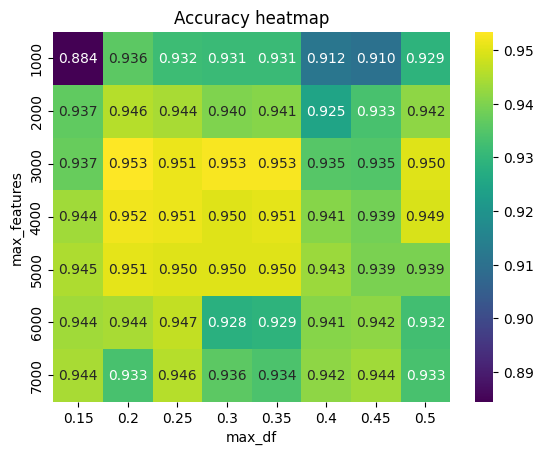

In [19]:
import warnings
warnings.filterwarnings("ignore")

max_features = [1000, 2000, 3000, 4000, 5000, 6000, 7000]
max_df = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

acc = []

for mf in max_features:
    for mdf in max_df:
        vectorizer = TfidfVectorizer(max_features=mf, max_df=mdf, token_pattern=r'\S{2,}')
        combined_data = pd.concat([train_data, test_data], axis=0)
        combined_tfidf = vectorizer.fit_transform(combined_data['Text'])

        nmf = NMF(n_components=5, max_iter=10, l1_ratio=0.5, solver='mu', beta_loss='kullback-leibler')
        combined_W = nmf.fit_transform(combined_tfidf)

        combined_pred = combined_W.argmax(axis=1)

        best_perm, best_acc = best_permutation_accuracy(combined_pred[:len(train_data)], train_data['Category'])

        acc.append((mf, mdf, best_acc))

# heatmap
acc_df = pd.DataFrame(acc, columns=['max_features', 'max_df', 'accuracy'])
acc_df_pivot = acc_df.pivot(index='max_features', columns='max_df', values='accuracy')
sns.heatmap(acc_df_pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title('Accuracy heatmap')
plt.xlabel('max_df')
plt.ylabel('max_features')
plt.show()

It looks like the best accuracy is around max_features=3000 and max_df=0.3. I will build the final model, with more iterations for the NMF:

In [20]:
vectorizer = TfidfVectorizer(max_features=3000, max_df=0.3, token_pattern=r'\S{2,}')

combined_data = pd.concat([train_data, test_data], axis=0)
combined_tfidf = vectorizer.fit_transform(combined_data['Text'])

nmf = NMF(n_components=5, max_iter=2000, solver='mu', beta_loss='kullback-leibler')
combined_W = nmf.fit_transform(combined_tfidf)

combined_pred = combined_W.argmax(axis=1)

best_perm, best_acc = best_permutation_accuracy(combined_pred[:len(train_data)], train_data['Category'])

print(best_acc)

# submission
test_pred_category = [best_perm[i] for i in combined_pred[len(train_data):]]
test_data['Category'] = test_pred_category
test_data[['ArticleId', 'Category']].to_csv('NMFi.csv', index=False)

# submission accuracy: 0.95374

0.9589422407794015


As a result of optimizations and hyper-parameters tuning, the accuracy has raised to 0.959 for train set and 0.95374 for test set.

#### Improvement to NMF model

It was very hard to improve the NMF permormance further, and I tried many different options, including using "bag of words" as a vectorizer, binary word vectors, using different number of components for the W matrix, using logistic regression for prediction (instead of selecting the max weight) and many others.
As an example for a very slight improvement, I will use the following algorithms:
* take only 1000 articles from the train set
* exclude all articles with word count higher than 1100
* divide each article to 3 equal parts
* build 3 models from these parts, using TF-IDF and matrix factorization
* as a prediction use majority vote from the 3 models to choose the category
* in case of a draw, take the category with highest sum of weights from all the 3 models

The code is below:

In [25]:
vectorizer = TfidfVectorizer(max_features=10000, max_df=0.2, token_pattern=r'\S{2,}', sublinear_tf=True, smooth_idf=True)
train_data_1000 = train_data[:1000][train_data['word_count'] < 1100]
combined_data = pd.concat([train_data_1000, test_data], axis=0)

combined_data_parts = []
number_of_parts = 3
for i in range(number_of_parts):
    comb = combined_data.copy()
    comb['Text'] =  comb['Text'].apply(lambda x: x[len(x)//number_of_parts*i:len(x)//number_of_parts*(i+1)])
    combined_data_parts.append(comb)

combined_tfidf = [vectorizer.fit_transform(comb['Text']) for comb in combined_data_parts]

# train NMF for each part
W = []
for i in range(number_of_parts):
    nmf = NMF(n_components=5, max_iter=3000, solver='mu', beta_loss='kullback-leibler')
    W.append(nmf.fit_transform(combined_tfidf[i]))


# use permutation to find the the mapping
best_perm_part = []
for i in range(number_of_parts):
    best_perm, best_acc = best_permutation_accuracy(W[i].argmax(axis=1)[:len(train_data_1000)], train_data_1000['Category'])
    best_perm_part.append(best_perm)
    print("Part", i, ":", best_acc)

# inverse the mapping
best_perm_inv = [{v: k for k, v in best_perm.items()} for best_perm in best_perm_part]

# combine the predictions
combined_pred = []
for i in range(len(train_data_1000)):
    majority_vote = {}
    weights = {}
    for j in range(number_of_parts):
        pred = W[j][i].argmax()
        pred_cat = best_perm_part[j][pred]
        if pred_cat in majority_vote:
            majority_vote[pred_cat] += 1
        else:
            majority_vote[pred_cat] = 1
        if pred_cat in weights:
            weights[pred_cat] += pred
        else:
            weights[pred_cat] = pred
    for cat in majority_vote:
        majority_vote[cat] += weights[cat] / 100
    combined_pred.append(max(majority_vote, key=majority_vote.get))

# accuracy
print("Final accuracy:", accuracy_score(train_data_1000['Category'], combined_pred))


# submission
test_pred = []

for i in range(len(test_data)):
    majority_vote = {}
    weights = {}
    for j in range(number_of_parts):
        pred = W[j][i+len(train_data_1000)].argmax()
        pred_cat = best_perm_part[j][pred]
        if pred_cat in majority_vote:
            majority_vote[pred_cat] += 1
        else:
            majority_vote[pred_cat] = 1
        if pred_cat in weights:
            weights[pred_cat] += pred
        else:
            weights[pred_cat] = pred
    for cat in majority_vote:
        majority_vote[cat] += weights[cat] / 1000
    test_pred.append(max(majority_vote, key=majority_vote.get))

test_data['Category'] = test_pred
test_data[['ArticleId', 'Category']].to_csv('NMFe.csv', index=False)

# submission accuracy: 0.95646

Part 0 : 0.9466800804828974
Part 1 : 0.8843058350100603
Part 2 : 0.9185110663983903
Final accuracy: 0.959758551307847


As seen above, there was a very minor improvement of accuracy. Train set accuracy: 0.959, test set accuracy: 0.95646

### 3. Supervised learning model

I will build a Logistic Regression model which uses the tfidVectorizer data directly:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_data['Text'], train_data['Category'], test_size=0.2, random_state=38)

# Create a TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=6000, max_df=0.3, token_pattern=r'\S{2,}')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

# Predict the validation set
y_pred = model.predict(X_val_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

# submission
X_train = train_data['Text']
y_train = train_data['Category']
X_test = test_data['Text']

vectorizer = TfidfVectorizer(max_features=6000, max_df=0.3, token_pattern=r'\S{2,}')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)
test_pred = model.predict(X_test_tfidf)

test_data['Category'] = test_pred
test_data[['ArticleId', 'Category']].to_csv('LR.csv', index=False)

# submission accuracy: 0.97959


Accuracy: 0.9652777777777778


The accuracy of the Logistic Regression model is 0.965. Test set accuracy 0.97959.

I will check now how train data size affects the results of both approaches:

In [23]:
for i in [150, 300, 750]:
    X_train = train_data['Text'][:i]
    y_train = train_data['Category'][:i]
    X_test = test_data['Text']

    vectorizer = TfidfVectorizer(max_features=6000, max_df=0.3, token_pattern=r'\S{2,}')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train_tfidf, y_train)
    test_pred = model.predict(X_test_tfidf)

    test_data['Category'] = test_pred
    test_data[['ArticleId', 'Category']].to_csv('LR' + str(i) + '.csv', index=False)

In [24]:
vectorizer = TfidfVectorizer(max_features=3000, max_df=0.3, token_pattern=r'\S{2,}')

for i in [150, 300, 750]:
    train_data_subset = train_data[:i]
    combined_data = pd.concat([train_data_subset, test_data], axis=0)
    combined_tfidf = vectorizer.fit_transform(combined_data['Text'])

    nmf = NMF(n_components=5, max_iter=2000, solver='mu', beta_loss='kullback-leibler')
    combined_W = nmf.fit_transform(combined_tfidf)

    combined_pred = combined_W.argmax(axis=1)

    best_perm, best_acc = best_permutation_accuracy(combined_pred[:len(train_data_subset)], train_data_subset['Category'])

    # submission
    test_pred_category = [best_perm[i] for i in combined_pred[len(train_data_subset):]]
    test_data['Category'] = test_pred_category
    test_data[['ArticleId', 'Category']].to_csv('NMF' + str(i) + '.csv', index=False)

### Results:
(obtained from Kaggle submission)

| Number of articles | NMF     | LR      |
| :----------------- | :------ | :------ |
| 150                | 0.86258 | 0.80544 |
| 300                | 0.71428 | 0.91020 |
| 750                | 0.95374 | 0.97006 |

As at seen from the table above both models converge to their final accuracy with 50% of the train set. Which means they are both efficient.

### Conclusion

In this project I've built a Matrix Factorization model for text classification and compared it to Logistic regression model. Both models performed well. The accuracy of the NMF model on the test set was 0.95646, and the accuracy of the Logistic Regression model was slightly better: 0.97959. Both models used TF-IDF as word features extraction technique.

As a conclusion, it looks like Logistic regression model has a better performance and is much simpler to set up and work with. NMF model requires an additional step of mapping the categories to W matrix components, while Logistic regression does this out of the box. NMF also requires a fixed set of categories, as it is needed for model construction. While Logistic Regression does not require this knowledge in advance.

An important preprocessing step in this problem is the feature extraction. TF-IDF turned out to be a great choice for that. It is highly customiseble, which allows to tune it for a specific problem. What's interesting is that the actual meaning of the words is not important, as well as relationships between words. Which shows that category classification tasks can be done effectively with simple models, without relying on complex word embedding techniques.

### References

*TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf*

*Word embedding: https://en.wikipedia.org/wiki/Word_embedding*